# Détection de fraude bancaire
### Big Data Mining M2 SISE : Pauline Lainé - Khánh Hoàng Lê

## 1. Introduction

Lorsqu'un client paye par chèque, il se peut que celui-ci ne paye jamais son panier, nous sommes alors dans le cas d'une fraude. Deux raisons peuvent être dû à une fraude. 

Le premier cas, c'est lorsque nous sommes dans le cas d'un chèque dit impayé, ce cas de figure apparait lorsque la personne ne possède pas le solde sur son compte en banque. L'autre cas de figure c'est lorsque nous avons à faire à un faux chèque. Un faux chèque peut se caractériser par une fausse identité ou lorsque le CMC7 est incorrect. Le CMC7 est une série de Caractères Magnétiques Codés à 7 bâtonnets situé en bas d'un chèque.

Sur une période de 10 mois, ces fraudes se compte au nombre de 20 000 soit 0.6% des transactions réalisées, réprésentant un chiffre d'affaires de 2 millions d'euros qui équivaut à 1.1% du chiffre d'affaires total de l'enseigne. C'est un chiffre d'affaires perdu non négligable. 

Notre étude va alors se porter sur la détection des fraudes par chèque dans un contexte déséquilibré.

## 2. Les données

Les données que nous allons utiliser provienne d'une enseigne de grande distribustion et d'organismes bancaires tels que la FNCI et la Banque de France. Nous avons une ligne par transaction sur la période du 21/03/2016 au 19/10/2016 soit une période de 7 mois. Chaque transaction est décrite par les 23 variables suivantes : 

- ZIBZIN : identifiant bancaire relatif à la personne
- IDAvisAutorisAtionCheque : identifiant de la transaction en cours
- Montant : montant de la transaction
- DateTransaction : date de la transaction
- CodeDecision : il s’agit d’une variable qui peut prendre ici 4 valeurs
    - 0 : la transaction a été acceptée par le magasin
    - 1 : la transaction et donc le client fait partie d’une liste blanche (bons payeurs). Aucun dans cette base de données
    - 2 : le client fait d’une partie d’une liste noire, son historique indique c'est un mauvais payeur (des impayés en cours ou des incidents bancaires en cours), sa transaction est alors automatiquement refusée
    - 3 : client ayant était arrêté par le système par le passé pour une raison plus ou moins fondée
- VérifianceCPT1 : nombre de transactions effectuées par le même identifiant bancaire au cours du même jour
- VérifianceCPT2 : nombre de transactions effectuées par le même identifiant bancaire au cours des trois derniers jours
- VérifianceCPT3 : nombre de transactions effectuées par le même identifiant bancaire au cours des sept derniers jours
- D2CB : durée de connaissance du client (par son identifiant bancaire), en jours. Pour des contraintes légales, cette durée de connaissance ne peut excéder deux ans
- ScoringFP1 : score d’anormalité du panier relatif à une première famille de produits (ex : denrées alimentaires)
- ScoringFP2 : score d’anormalité du panier relatif à une deuxième famille de produits(ex : électroniques)
- ScoringFP3 : score d’anormalité du panier relatif à une troisième famille de produits (ex : autres)
- TauxImpNb_RB : taux impayés enregistrés selon la région où a lieu la transaction
- TauxImpNB_CPM : taux d’impayés relatif au magasin où a lieu la transaction
- EcartNumCheq : différence entre les numéros de chèques
- NbrMagasin3J : nombre de magasins différents fréquentés les 3 derniers jours
- DiffDateTr1 : écart (en jours) à la précédente transaction
- DiffDateTr2 : écart (en jours) à l’avant dernière transaction
- DiffDateTr3 : écart (en jours) à l’antépénultième transaction
-  CA3TRetMtt : montant des dernières transactions + montant de la transaction en cours
- CA3TR : montant des trois dernières transactions
- Heure : heure de la transaction
- FlagImpaye : acception (0) ou refus de la transaction (1)

Cette dernière variable "FlagImpaye" est celle que nous cherchons à prédire. La classe 0 correspondant aux transactions normales et acceptées et la classe 1 correspond aux fraudes, les transactions qui sont refusées.

Voyons à présent de plus près à quoi ressemble nos données.

#### Importation des librairies 

In [178]:
import numpy as np
import pandas as pd
import missingno as mn
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit, cross_val_score,cross_val_predict
from sklearn.metrics import recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score 
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from time import time
import seaborn as sns
import imblearn
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from collections import OrderedDict
print(imblearn.__version__)

0.7.0


### 2.1. Importation du jeu de données 

In [2]:
import os
#os.chdir("D:/OneDrive/Documents/COURS/M2 SISE/Big Data Mining/Projet")
#df = pd.read_csv("dataproject.csv",encoding="utf-8",header=0, sep =";",decimal=',')
df =pd.read_csv("/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/dataproject.csv",encoding="utf-8",header=0, sep =";",decimal=',')

In [17]:
df.head()

,ZIBZIN,IDAvisAutorisAtionCheque,MontAnt,DAteTrAnsAction,CodeDecision,VerifiAnceCPT1,VerifiAnceCPT2,VerifiAnceCPT3,D2CB,ScoringFP1,...,TAuxImpNB_CPM,EcArtNumCheq,NbrMAgAsin3J,DiffDAteTr1,DiffDAteTr2,DiffDAteTr3,CA3TRetMtt,CA3TR,Heure,FlAgImpAye
0,A034010041908012010710730,71051532,40.17,2016-03-21 07:47:38,0,1,1,1,535,0.0,...,21.834061,0,1,4.0,4.0,4.0,40.17,0.0,28058,0
1,A035010041908006493331734,71051533,20.00,2016-03-21 08:04:57,0,0,0,0,358,0.0,...,12.586532,0,1,4.0,4.0,4.0,20.00,0.0,29097,0
2,A013010003908005150136747,71051534,35.00,2016-03-21 08:06:45,0,0,0,0,199,0.0,...,39.274924,0,1,4.0,4.0,4.0,35.00,0.0,29205,0
3,A013010041908025639221029,71051536,20.00,2016-03-21 08:11:38,0,0,0,0,38,0.0,...,39.274924,0,1,4.0,4.0,4.0,20.00,0.0,29498,0
4,A013010003908005556100283,71051538,20.00,2016-03-21 08:17:11,0,0,0,0,26,0.0,...,39.274924,0,1,4.0,4.0,4.0,20.00,0.0,29831,0


In [18]:
print(np.shape(df))
print(df.info())

(2231369, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ZIBZIN                    object 
 1   IDAvisAutorisAtionCheque  int64  
 2   MontAnt                   float64
 3   DAteTrAnsAction           object 
 4   CodeDecision              int64  
 5   VerifiAnceCPT1            int64  
 6   VerifiAnceCPT2            int64  
 7   VerifiAnceCPT3            int64  
 8   D2CB                      int64  
 9   ScoringFP1                float64
 10  ScoringFP2                float64
 11  ScoringFP3                float64
 12  TAuxImpNb_RB              float64
 13  TAuxImpNB_CPM             float64
 14  EcArtNumCheq              int64  
 15  NbrMAgAsin3J              int64  
 16  DiffDAteTr1               float64
 17  DiffDAteTr2               float64
 18  DiffDAteTr3               float64
 19  CA3TRetMtt                float64
 20  CA3TR     

Nous avons une base de données de plus de 2 millions de transactions (2 231 369) caractérisé par 23 variables. La plus part sont quantitatives de type "int64" et "float64". Deux variables sont de type qualitative : l'indentifiant de la personne (ZIBZIN) et la date de la transaction (DAteTrAnsAction).

### 2.2. Valeurs manquantes

Avant de faire des analyses sur nos données. Nous allons dans un premier vérifier si nous avons des valeurs manquantes dans notre jeu de données.  

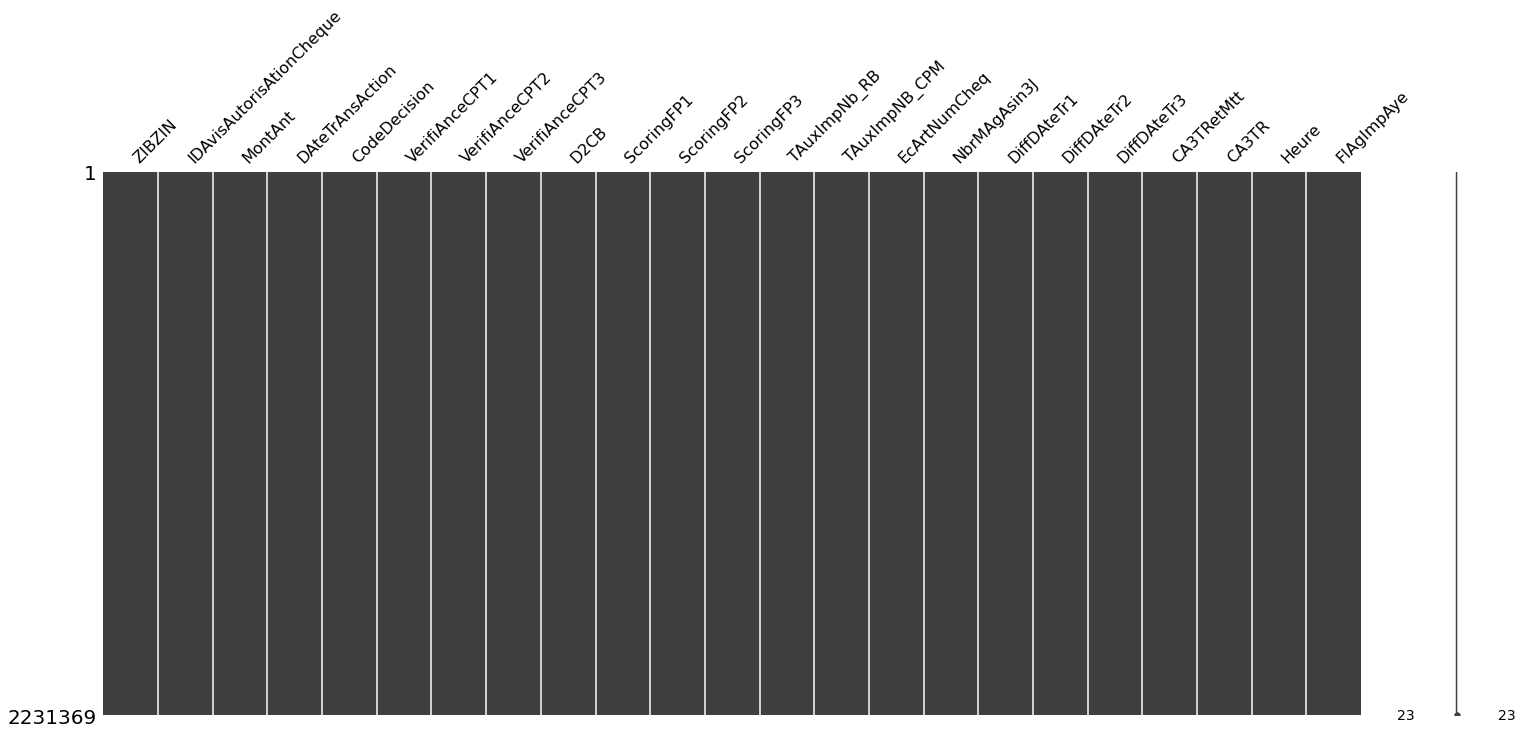

In [19]:
# Matrice des valeurs nulles
mn.matrix(df)

In [21]:
#Nombre de valeurs nulles par variable
print(df.isnull().sum())

ZIBZIN                      0
IDAvisAutorisAtionCheque    0
MontAnt                     0
DAteTrAnsAction             0
CodeDecision                0
VerifiAnceCPT1              0
VerifiAnceCPT2              0
VerifiAnceCPT3              0
D2CB                        0
ScoringFP1                  0
ScoringFP2                  0
ScoringFP3                  0
TAuxImpNb_RB                0
TAuxImpNB_CPM               0
EcArtNumCheq                0
NbrMAgAsin3J                0
DiffDAteTr1                 0
DiffDAteTr2                 0
DiffDAteTr3                 0
CA3TRetMtt                  0
CA3TR                       0
Heure                       0
FlAgImpAye                  0
dtype: int64


Notre jeu de données comporte aucune valeur nulle. Nous allons maintenant pouvoir faire quelques analyses sur nos données.

### 2.3. Analyse univarié

##### Matrice de corrélation

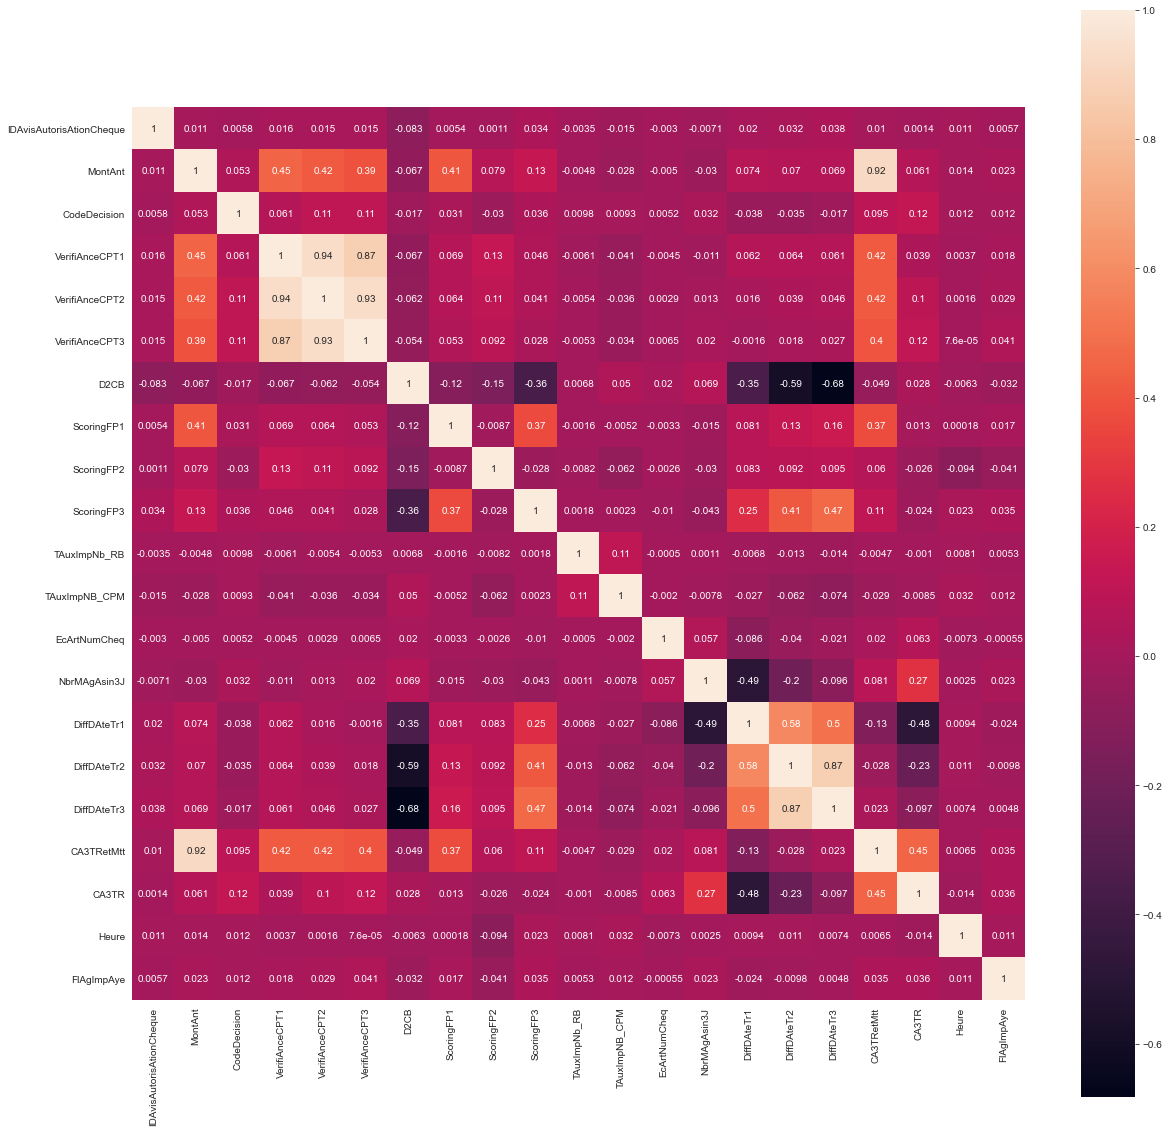

In [22]:
from matplotlib import pyplot
import seaborn as sns
#Matrice de corrélation
sns.set_style("darkgrid")
pyplot.figure(figsize=(20, 20))
sns.heatmap(df.corr(), square=True, annot=True)

Lorsqu'on regarde la matrice de correlation on voit qu'aucune variables est corrélées à notre variables cible. Le plus gros score qu'on observe est 0.041 ce qui est très faible.

##### Description des variables

In [23]:
df.describe()

,IDAvisAutorisAtionCheque,MontAnt,CodeDecision,VerifiAnceCPT1,VerifiAnceCPT2,VerifiAnceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,...,TAuxImpNB_CPM,EcArtNumCheq,NbrMAgAsin3J,DiffDAteTr1,DiffDAteTr2,DiffDAteTr3,CA3TRetMtt,CA3TR,Heure,FlAgImpAye
count,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,...,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06
mean,7.356762e+07,5.991771e+01,1.288043e-02,3.991402e-01,4.296752e-01,4.816980e-01,2.477938e+02,3.100542e+00,6.882686e-01,1.769416e-01,...,3.256122e+01,6.724334e+03,1.034200e+00,3.947808e+00,4.234163e+00,4.266234e+00,6.683475e+01,6.917041e+00,5.347306e+04,2.804108e-03
std,1.458268e+06,7.980922e+01,1.682062e-01,5.250070e-01,6.056457e-01,7.339127e-01,2.131088e+02,3.047480e+01,9.336748e+00,5.662696e-01,...,3.475789e+01,1.742520e+05,1.862585e-01,1.078915e+00,5.510923e-01,4.643674e-01,8.929606e+01,3.550385e+01,1.200173e+04,5.287955e-02
min,7.105153e+07,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-4.969986e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,4.745370e-04,1.365741e-03,1.000000e-02,0.000000e+00,1.336000e+03,0.000000e+00
25%,7.232987e+07,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.874265e-03,-2.869431e+00,1.179973e-03,...,1.390821e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,2.792000e+01,0.000000e+00,4.248500e+04,0.000000e+00
50%,7.353719e+07,4.235000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.430000e+02,1.543502e-02,0.000000e+00,2.131271e-03,...,2.526529e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.732000e+01,0.000000e+00,5.488200e+04,0.000000e+00
75%,7.480167e+07,7.205000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.680000e+02,1.370299e-01,5.289664e+00,1.533859e-02,...,3.927492e+01,0.000000e+00,1.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,8.130000e+01,0.000000e+00,6.390700e+04,0.000000e+00
max,7.619241e+07,1.698534e+04,3.000000e+00,1.500000e+01,4.000000e+01,4.000000e+01,5.510000e+02,1.680000e+04,4.702998e+01,1.839140e+01,...,7.142857e+02,9.993474e+06,1.000000e+01,5.000000e+00,5.000000e+00,5.000000e+00,1.698534e+04,1.060000e+04,8.256400e+04,1.000000e+00


L'ordre de grandeur des variables varie enormement, il faudra penser à standardiser les données pour nos prédictions. 
Regardons le montant de la transaction, qui est une variable importante pour notre problématique. On peut voir que le montant moyen d'une transaction est proche de 60€. Avec la plus petite transaction qui est inférieur à 1€ et la transaction la plus élevé qui est d'environ 17K€. On voit donc un très grand écart entre c'est deux valeurs. La dispersion de cette variable est élevé. Regardons la distribution de cette variable.

[Text(0, 0.5, 'Distribution')]

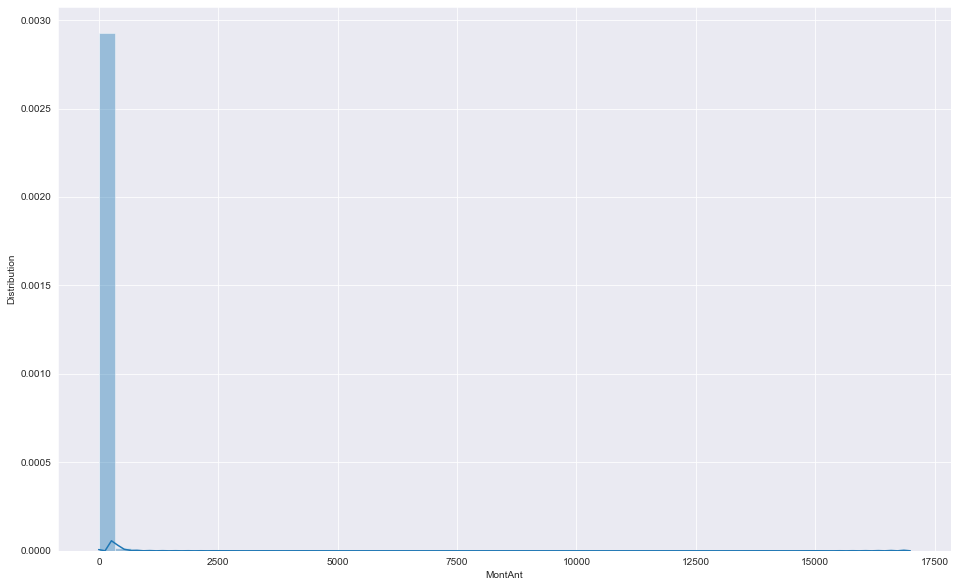

In [24]:
#Distribution de la variable Montant
plt.figure(figsize=(16, 10))
ax = sns.distplot(df["MontAnt"])
ax.set(ylabel="Distribution")  

Quand on regarde la distribution du montant des transactions on voit que la plus part des transactions sont inférieur à 500€. On a très peu de transactions avec une montant très élevé. 
Regardons à présent les deux variables quantitatives discrètes "FlAgImpAye" et "CodeDecision" afin de voir la répartion de ces variables dans cette base.

##### Code Décision : 
Cette variable rappelons-le elle permet de definir si la transaction à été accepter ou refuser soit parce que le client fait partie d'une liste noir soit parce que le système à déjà arrêtés le clients. Cette variable peut prendre 4 valeurs possible (0,1,2 ou 3). Sachant qu'il n'y a normalement aucune valeur 1 dans cette base de données. Nous souhaitons voir la répartition de chacune des valeurs possibles.  

In [25]:
#Répartion de la variable CodeDecision
pd.value_counts(df['CodeDecision'])

0    2218002
2      11360
3       2007
Name: CodeDecision, dtype: int64

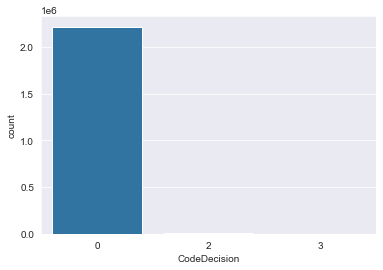

In [26]:
#Barplot
ax = sns.countplot(x="CodeDecision", data=df)

On voit donc que en effet la valeur 1 concernant les clients bon payeurs qui font partie d'une liste blanche ne fait pas partie de cette base. De plus on peut voir que notre jeu de données est composé en majorité de transactions qui ont été aceptées par l'enseigne.

##### Variable cible : FlAgImpAyes

Comme dit précedemment la variable que nous cherchons à prédire est "FlAgImpAyes", il semble donc important de voir la répartition de cette variable, sachant qu'elle peut prendre que 2 valeurs possibles (0 ou 1). 


In [27]:
#Répartion de la variable cible FlAgImpAye en %
print(pd.value_counts(df['FlAgImpAye'])/len(df)) 

0    0.997196
1    0.002804
Name: FlAgImpAye, dtype: float64


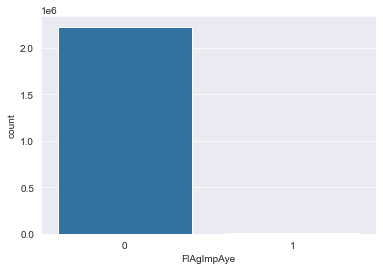

In [28]:
#Barplot
ax = sns.countplot(x="FlAgImpAye", data=df)

On voit donc voit que la classe 1 dite "frauduleuse" est extremement petite par rapport à la classe normale (0). Elle représente 0.28% de notre jeu de données. Plus de 99% de nos données sont donc de la classe normale. Nous sommes dans une environnement extrêmement déséquilibré. Nos prédictions seront faussées et risque de prédire tout le temps la classe majoritaire. Nous devons prendre en compte cet élément pour palier à ça. On va donc procéder à un oversampling pour équilibré nos classes sans perdre des informations importantes sur les classes. Nous allons également tester sur les modèles qui le permette une méthode qui permet de pondérer les données en fonction de sa classe. 

On se demande si le montant des transactions est différent en fonction de la classe. C'est ce que nous allons voir.

##### Relation entre le type de transaction et le montant de celle ci

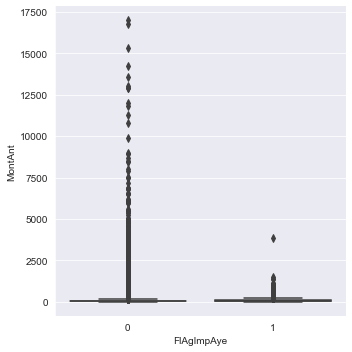

In [29]:
#Relation entre la classe et le montant
sns.catplot(x="FlAgImpAye", y="MontAnt", kind="box", data=df)

Il ne semble pas y avoir une grande différence entre le montant moyen des transaction de ces deux classes. Néanmoins on voit que les transactions les plus élevées sont des transactions qui ne sont pas frauduleuses. Les transactions de la classe frauduleuses sont moins dispersées.

##### Date transaction

Il nous reste une variable importante à regarder de plus près. C'est la variable de la date de transaction (DAteTrAnsAction). Nous allons commencer par la transformer pour quel soit au bon format "datetime".

In [3]:
#Transformation de la date au format datetime
df['DAteTrAnsAction'] = pd.to_datetime(df['DAteTrAnsAction'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 23 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ZIBZIN                    object        
 1   IDAvisAutorisAtionCheque  int64         
 2   MontAnt                   float64       
 3   DAteTrAnsAction           datetime64[ns]
 4   CodeDecision              int64         
 5   VerifiAnceCPT1            int64         
 6   VerifiAnceCPT2            int64         
 7   VerifiAnceCPT3            int64         
 8   D2CB                      int64         
 9   ScoringFP1                float64       
 10  ScoringFP2                float64       
 11  ScoringFP3                float64       
 12  TAuxImpNb_RB              float64       
 13  TAuxImpNB_CPM             float64       
 14  EcArtNumCheq              int64         
 15  NbrMAgAsin3J              int64         
 16  DiffDAteTr1               float64       
 17  DiffDAte

In [4]:
#Extraction du mois
df['Month']=df['DAteTrAnsAction'].dt.month
a=pd.value_counts(df['Month'])
#Les différents mois present dans la base de données
print(df['Month'].unique())

[ 3  4  5  6  7  8  9 10]


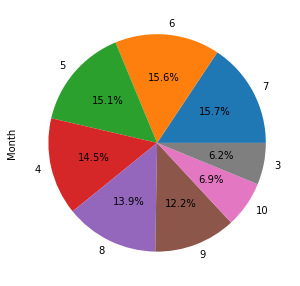

In [5]:
#Répartion par mois
plot = a.plot.pie(y='Month', figsize=(5, 5),autopct='%1.1f%%')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 24 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ZIBZIN                    object        
 1   IDAvisAutorisAtionCheque  int64         
 2   MontAnt                   float64       
 3   DAteTrAnsAction           datetime64[ns]
 4   CodeDecision              int64         
 5   VerifiAnceCPT1            int64         
 6   VerifiAnceCPT2            int64         
 7   VerifiAnceCPT3            int64         
 8   D2CB                      int64         
 9   ScoringFP1                float64       
 10  ScoringFP2                float64       
 11  ScoringFP3                float64       
 12  TAuxImpNb_RB              float64       
 13  TAuxImpNB_CPM             float64       
 14  EcArtNumCheq              int64         
 15  NbrMAgAsin3J              int64         
 16  DiffDAteTr1               float64       
 17  DiffDAte

Donc notre base de données répresente 8 mois différents de mars à octobre. Ce graphique nous montre la répartition des transactions en fonction du mois. Le mois qui enregistre le plus de transactions est le mois de juillet. A contrario les mois qui ont le moins d'activité est le mois et mars suivit de près par octobre, ce qui s'explique nottament par le fait que nous n'avons pas les transactions sur le mois complet.

La première étape d'analyse de la base est fini. Nous allons pouvoir passer à la création de nos bases de test et d'entrainement.

## 3. Création des ensembles de données

L'objectif ici est de creer notre base d'apprentissage et de test en fonction de la date de la transaction. Puis à partir de la base d'apprentissage nous créerons deux sous-ensembles. Un ensemble d'entrainement et un ensemble de validation.

### 3.1. Ensembles d'apprentissage et de test

- Notre base d'apprentissage comprendra les transactions ayant eu lieu entre le "2016-03-21" et le "2016-09-19". 
- Notre base de test les transactions ayant eu lieu entre le "2016-09-20" et le "2016-10-19".

In [110]:
#Apprentissage
Apprenti = df.loc[df['DAteTrAnsAction'] < '2016-09-20'] 
#Test
Test = df.loc[df['DAteTrAnsAction'] >= '2016-09-20'] 

Une fois notre base divisé en deux ensembles. On créé notre ensemble de variables explicatives et notre variable cible. 


Nous allons garder seulement les variables qui nous semble les plus utiles. Nous avons donc décidés d'enlever les variables d'identifiants, la variable de date ainsi que l'heure des transactions. 


Nous regroupons ces variables dans une base nommée "training_features" pour la base d'apprentissage et "test_features" pour le test. Dans une base "training_target" et "test_target" nous mettons notre variable cible qui représente la classe de la transaction (FlAgImpAye). 

In [33]:
#Apprentissage
#Variables explicatives
training_features= Apprenti.drop(Apprenti.columns[[0, 1,3,21,22,23]], axis=1) 
#Variables cible
training_target = Apprenti['FlAgImpAye']

In [111]:
#Test
#Variables explicatives
test_features= Test.drop(Apprenti.columns[[0, 1, 3,21,22]], axis=1) 
#Variable cible
test_target = Test['FlAgImpAye']

### 3.2. Ensembles d'entrainement et de validation
A partir de notre base d'apprentissage on va pouvoir créer notre ensemble d'entrainement et notre ensemble de validation. 
On a dans un premier temps décidé de répartir les données en 70% pour l'entrainement et 30% pour le test. La répartition était donc la suivante : 
- Transaction du 2016-03-21 au 2016-07-22 pour l'ensemble d'entrainement. 
- Transaction du 2016-07-22 au 2016-09-19 pour la base de validation.
Avec cette répartition nous obtenions au maximun une mesure f1 de 13% lors de la phase de validation.


Nous avons cherché à améliorer cette mesure en modifiant notre manière de diviser la base. Nous sommes donc partis sur une répartition en fonction de la date. En prenant 1 mois de transactions pour l'ensemble de validation et le reste pour l'ensemble d'entrainement, soit 5 mois. Cette répartition permet d'obtenir de meilleurs résultats nous avons donc choisit cette option et nous obtenons la répartition suivantes : 
- Transaction du 2016-03-21 au 2016-08-19 pour l'ensemble d'entrainement. 
- Transaction du 2016-08-20 au 2016-09-19 pour la base de validation.

In [103]:
#Entrainement
entrainement = Apprenti.loc[df['DAteTrAnsAction'] < '2016-08-20'] 
#Validation
validation = Apprenti.loc[df['DAteTrAnsAction'] >= '2016-08-20'] 

In [104]:
x_train= entrainement.drop(Apprenti.columns[[0, 1, 3,21,22]], axis=1) 
y_train = entrainement['FlAgImpAye']
x_val= validation.drop(Apprenti.columns[[0, 1, 3,21,22]], axis=1) 
y_val = validation['FlAgImpAye']

In [14]:
#information sur train
print(pd.value_counts(y_train))
print(np.shape(x_train))

0    1673087
1       4454
Name: FlAgImpAye, dtype: int64
(1677541, 19)


## 4. Mesure d'évaluation le F1 Score 

En classification plusieurs mesures peuvent être utiliser pour evaluer la qualité d'un modèle. Par exemple la precision, le rappel, la courbe ROC, l'accuracy ou bien la f-mesure. Toutes ces mesures ne sont pas forcement adaptées à notre problème. 

Par exemple l'accuracy n'est pas une indicateur fiable lorsque nous somme dans un environnement déséquilibré. En effet avec un jeu de données où plus de 99% de nos données appartienne à la première classe si notre algorithme prédit toutes nos transaction comme appartenant à la première classe nous aurons une accuracy très élevée mais pourtant le modèle sera mauvais car il predira toujours la même classe.

La précision permet de calculer la proportion de predictions positives qui sont réellement positives. Permet ainsi de réduire l'erreur de prédiction des transactions frauduleuses.  Le rappel lui nous donne la proportion de données positives qui ont été correctement predites. C'est à dire la part des fraudes qui ont été détecter. 

Dans notre problème il est important de detecter le maximum de fraudes mais il est également important de ne pas prédire des fausses fraudes. En effet accusé un client de fraudes alors que ce n'est pas la cas peut avoir des conséquences. Ainsi pour maximiser la prédiction de fraudes et minimiser l'erreur de prédiction, une mesure existe, c'est la f-mesure.  L'objectif va être de maximiser celle-ci pour obtenir le meilleur modèle.

D'ailleurs, nous pouvons utiliser les measures suivant pour les bases de données imbalance:

- Recall
- Precision
- F1-score
- Area Under ROC curve.


Formulaire:
- Recall = TP / (TP + FN)
- Precision = TP / (TP + FP)
- F1-Score = 2*P*R / (P + R) here P for Precision, R for Recall

## 5. Échantillonnage

Afin de résoudre le problème de l'apprentissage dééquilibrés, le ré-échantiollanage est le méthode le plus utilisé. L’objectif est de modifier notre base de données avant d’entraîner le modèle prédictif afin d’avoir des données plus équilibrées.

Il éxiste deux catégories d'échantillonnages : les sous-echantillonnage (undersampling) qui consiste à supprimer des données de la classe majoritaire et sur-echantillonnage (oversampling) qui lui va rajouter des données dans la classe minoritaire. 

### 5.1. SMOTE

Comme nous l'avons vu la classe majoritaire contient plus de 99% des données. Réaliser un undersampling supprimerai alors presque la totalité des données. Ainsi pour garder le maximum de d'information, nous avons décidé de réaliser un oversampling avec la méthode SMOTE.

Le principe de SMOTE est de générer de nouveaux échantillons en combinant les données de la classe minoritaire avec celles de leurs voisins proches. Techniquement, on peut décomposer SMOTE en 5 étapes :

- Choix d’un vecteur caractéristique de notre classe minoritaire que nous appellerons vc ;

- Sélection des k-voisins les plus proches (k=5 par défaut) et choix de l’un d’eux au hasard que l’on appellera pv ;

- Calcul de la différence pour chaque valeur caractéristique (feature value) i, vc[i]-pv[i] et multiplication de celle-ci par un nombre aléatoire entre [0,1];

- Ajout du résultat précédent à la valeur de la caractéristique i du vecteur vc afin d’obtenir un nouveau point (une nouvelle donnée) dans l’espace des caractéristiques ;

- Répétition de ces opérations pour chaque point de données de la classe minoritaire ;



In [15]:
#Réalisation du SMOTE
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [16]:
#Vérification
print(np.shape(x_train_res))
print(pd.value_counts(y_train_res)/len(y_train_res))

(3346174, 19)
1    0.5
0    0.5
Name: FlAgImpAye, dtype: float64


L'algorithme smote est exécuter sur l'algorithme d'entrainement. Notre variable cible est à présent équilibré, nous avons bien 50/50 dans chaque classe et plus de 3 millions de données.

### 5.1. ADASYN

A part de Randon Sampling, nous avons aussi ADASYN, la meilleur version de SMOTE. La principale différence entre SMOTE et ADASYN est la différence dans la génération de points d'échantillonnage synthétiques pour les points de données minoritaires. Dans ADASYN, on considère une distribution de densité rₓ qui décide ainsi du nombre d'échantillons synthétiques à générer pour un point particulier, alors que dans SMOTE, il y a un poids uniforme pour tous les points minoritaires. A cause de niveau de temps d'éxecution donc nous n'avons pas avancé ce partie  

# 6. Analyse Composant Principal

L’ACP nous permet de représenter les données en fonction des variables choisies, grâce à une projection dans un espace de deux dimensions. Les deux premiers axes de cette représentation sont composés de deux premières composantes principales de l’ACP, (ce sont Dim 1 et Dim 2). La troisième coordonnée de cette représentation est la valeur de la variable cible (nous utilisons la valeur brute normalisé de cette variable).

Sans SMOTE

In [43]:
print(pd.value_counts(y_train)/len(y_train))

0    0.997345
1    0.002655
Name: FlAgImpAye, dtype: float64


Text(0.5, 0.98, 'Premier plan factoriel')

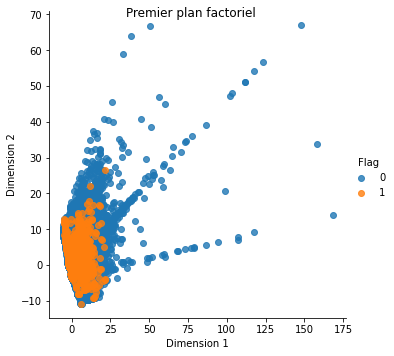

In [44]:
pca = PCA(n_components=2)
sc = StandardScaler() 
X_normalized = sc.fit_transform(x_train)  
components = pca.fit_transform(X_normalized)
# Transformation en DataFrame pandas
fraud_pca_df = pd.DataFrame({
    "Dim1" : components[:,0], 
    "Dim2" : components[:,1], 
    "Flag" : y_train
})
g_pca = sns.lmplot("Dim1", "Dim2", hue = "Flag", data = fraud_pca_df,fit_reg = False)
g_pca.set(xlabel = "Dimension 1", ylabel = "Dimension 2")
g_pca.fig.suptitle("Premier plan factoriel")

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_normalized) 
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
features=X.columns
fig=px.scatter(components, color=df[str(value1)], x=0, y=1, labels={'0':'PC1', '1':'PC2'})
features=y_train                
#Ajout de la sémantique des axes avec les variables d'origine 
for i, feature in enumerate(features):
    #on ne prend en compte que les variables quanti
    if str(X1.dtypes[str(feature)])!='object':
        fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
                        )
        fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
                        )

Les données ne sont pas très clair à distiguer les classes à cause de nombreux classes. Nous pouvons voir qu'il y a beaucoup plus de classe 0 que classe 1. Les classe sont assez concentré mais aussi mélangé de l'un à l'autre

Avec SMOTE:

Text(0.5, 0.98, 'Premier plan factoriel')

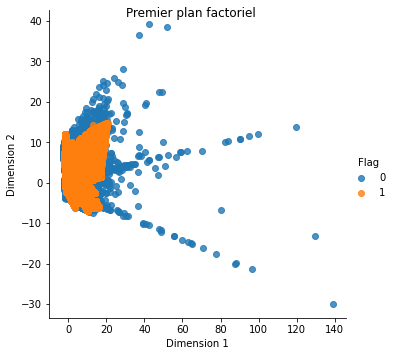

In [45]:
pca = PCA(n_components=2)
sc = StandardScaler() 
X_normalized_res = sc.fit_transform(x_train_res)  
components_res = pca.fit_transform(X_normalized_res) 
# Transformation en DataFrame pandas
fraud_pca_df_res = pd.DataFrame({
    "Dim1" : components_res[:,0], 
    "Dim2" : components_res[:,1], 
    "Flag" : y_train_res
})
g_pca_res = sns.lmplot("Dim1", "Dim2", hue = "Flag", data = fraud_pca_df_res, fit_reg = False)
g_pca_res.set(xlabel = "Dimension 1", ylabel = "Dimension 2")
g_pca_res.fig.suptitle("Premier plan factoriel")

Les classes sont encore dur à observer.

## 7. Algorithmes

Maintenant, nous pouvons construire les modèles en utilisant les algorithmes différents de machine learning. Avant de créer ce modèle, nous devons trouver le statement de notre problème, c'est à dire les algortihmes supervisé et non - supervisé.

En fait, notre problème tombe sur le supervisé qui suppose que la base de données a une value cible pour chaque ligne ou échantillon. 

Les algorithmes supervisé ont deux types:
- Classification 
- Regression 

Crédit card fraud détection est un problème de classification. La valeur cible est integer donc 1 ou 0 ou catégorique donc fraud ou non - fraud.

Pour résoudre notre problème nous avons décidé de tester plusieurs modèles de prédiction afin de trouver le meilleur qui maximisera notre valeur de f1.

Les algorithmes que nous allons appliquer sont :

- La forêt aléatoire (random forest)
- Les K plus proche voisins (k Nearest Neighbor)
- L'arbre de décision (Decision Tree)
- L'analyse discriminent linéaire
- Des modèles ensembliste
- Xgboost
- Modèle de one class classification : isolation forest
    
Pour chacun des algorithmes nous avons tester plusieurs valeurs pour les hyper-paramètres afin de trouver les meilleurs si le temps de calcul est optimisé. 

Nous n'allons pas faire une cross-validation pour les données comme les transaction sont chronologiques. Nous pourrions utiliser TimeSeriesSplit pour que ca repeste le chronologie de train et validation, cependant les taches semble plus compliqué et le résultat ne sera pas beaucoup plus améliorer

Sorties communes :
- Temps de calcul:
    Très simplement, il s’agit du temps en secondes qu’a mis le modèle en question pour trouver les résultats. Il démarre lorsque les paramètres sont choisis (optimaux ou manuel).
    
- Matrice de confusion sous forme graphique:
    La matrice de confusion est une matrice qui mesure la qualité d'un système de classification. Chaque ligne correspond à une classe réelle, chaque colonne correspond à une classe estimée. La cellule ligne L, colonne C contient le nombre d'éléments de la classe réelle L qui ont été estimés comme appartenant à la classe C1. Un des intérêts de la matrice de confusion est qu'elle montre rapidement si un système de classification parvient à classifier correctement.
    
- F1-score:
    La mesure F est la moyenne harmonique de la précision et de la sensibilité. Si vous optimisez votre classificateur pour augmenter l'un et défavoriser l'autre, la moyenne des harmoniques diminue rapidement. 
    
- Courbe ROC et AUC:
    La courbe ROC est un outil d’évaluation et de comparaison des modèles. L’idée est de faire varier le « seuil » de 1 à 0. AUC indique la probabilité pour que la fonction SCORE place un positif devant négatif (dans le meilleur des cas AUC =1

#### Dictionaire

In [162]:
#Ajout dictionnaire
test_result = {}
valid_result = {}
auc_result = {}
time_result = {}

### 7.1 K Nearest Neighbor

Knn ou méthode des k plus proches voisins est un algorithme standard de classification qui repose exclusivement sur le choix de la métrique de classification. Il est “non paramétrique” (seul k doit être fixé) et se base uniquement sur les données d’entraînement.

L’idée est la suivante : à partir d’une base de données étiquetées, on peut estimer la classe d’une nouvelle donnée en regardant quelle est la classe majoritaire des k données voisines les plus proches (d’où le nom de l’algorithme). Le seul paramètre à fixer est k, le nombre de voisins à considérer.

In [92]:
pipeKNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
startKNN = time()
pipeKNN.fit(x_train_res, y_train_res)  
endKNN = time()
KNN= (endKNN-startKNN)/60
print("temps d'execution",KNN)

temps d'execution 85.573710501194


##### Validation :

In [106]:
#Validation
f1_knn = round(f1_score(y_val, pipeKNN.predict(x_val)),6)
print(metrics.classification_report(y_val, pipeKNN.predict(x_val)))
print("Validation score f1 : ", f1_knn)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    288737
           1       0.03      0.11      0.05       948

    accuracy                           0.99    289685
   macro avg       0.51      0.55      0.52    289685
weighted avg       0.99      0.99      0.99    289685

Validation score f1 :  0.048721


##### Test :

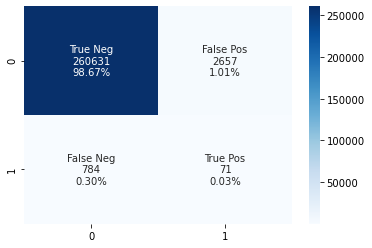

In [113]:
#Matrice de confusion
knn_matrix_val = confusion_matrix(test_target,pipeKNN.predict(test_features))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                knn_matrix_val.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     knn_matrix_val.flatten()/np.sum(knn_matrix_val)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(knn_matrix_val, annot=labels, fmt='', cmap='Blues')

In [114]:
#Test
test_knn = round(f1_score(test_target,pipeKNN.predict(test_features)),6)
print(metrics.classification_report(test_target,pipeKNN.predict(test_features)))
print("Test score f1 : ", test_knn)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    263288
           1       0.03      0.08      0.04       855

    accuracy                           0.99    264143
   macro avg       0.51      0.54      0.52    264143
weighted avg       0.99      0.99      0.99    264143

Test score f1 :  0.039632


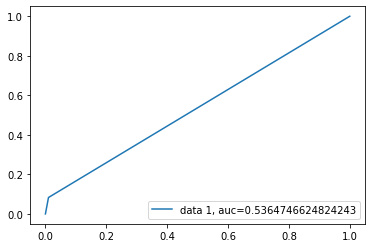

In [130]:
#Courbe ROC
fpr, tpr, _ = roc_curve(test_target, pipeKNN.predict(test_features))
auc_knn = metrics.roc_auc_score(test_target,pipeKNN.predict(test_features))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_knn))
plt.legend(loc=4)
plt.show()

Nous obtenos le f1 à 4% ce qui n'est pas très impressionnant. En plus avec le temps d'exécution est long et seulement 3 % Vrai Possitif donc knn n'est pas vraiment un modèle idéal.

In [163]:
#Ajout dictionnaire
test_result['KNN'] = test_knn
valid_result['KNN'] = f1_knn
auc_result['KNN']=round(auc_knn,3)
time_result['KNN']=round(KNN,3)
print(test_result)
print(valid_result)
print(auc_result)
print(time_result)

{'KNN': 0.039632}
{'KNN': 0.048721}
{'KNN': 0.536}
{'KNN': 85.574}


### 7.2 Decision Tree

Le second algorithme de classification que nous avons utilisé est l’arbre de classification. Il permet de prédire une variable cible discrète. Le principe est le même celui de l’arbre de décision, et fonctionne comme l’arbre de régression. L’arbre est construit grâce à un partitionnement récursif des données. Le principe est alors celui de séparer les données via des partitions, qui vont elles-mêmes se séparer à leur tour à mesure que l’on va descendre en profondeur dans l’arbre. Les avantages de cette méthode sont les mêmes que ceux que l’arbre de régression, les résultats obtenus par cette méthode sont très satisfaisants quand on les compare avec le rapide temps de calcul et la faible complexité de l’algorithme.

In [36]:
pipelineDT = make_pipeline(StandardScaler(), DecisionTreeClassifier())

In [37]:
paramsDT = {"decisiontreeclassifier__max_depth": [3,6,9,12, None],
              "decisiontreeclassifier__min_samples_leaf": np.arange(1,9,1),
              "decisiontreeclassifier__criterion": ["gini", "entropy"]}
#params = {'decisiontreeclassifier__max_depth': [3, None]}

In [38]:
sorted(pipelineDT.get_params().keys())

['decisiontreeclassifier',
 'decisiontreeclassifier__ccp_alpha',
 'decisiontreeclassifier__class_weight',
 'decisiontreeclassifier__criterion',
 'decisiontreeclassifier__max_depth',
 'decisiontreeclassifier__max_features',
 'decisiontreeclassifier__max_leaf_nodes',
 'decisiontreeclassifier__min_impurity_decrease',
 'decisiontreeclassifier__min_impurity_split',
 'decisiontreeclassifier__min_samples_leaf',
 'decisiontreeclassifier__min_samples_split',
 'decisiontreeclassifier__min_weight_fraction_leaf',
 'decisiontreeclassifier__presort',
 'decisiontreeclassifier__random_state',
 'decisiontreeclassifier__splitter',
 'memory',
 'standardscaler',
 'standardscaler__copy',
 'standardscaler__with_mean',
 'standardscaler__with_std',
 'steps',
 'verbose']

In [39]:
gridsearchDT = GridSearchCV(estimator=pipelineDT,
                       param_grid=paramsDT,
                       n_jobs=-1,
                       scoring='f1_micro')
startDT = time()
gridsearchDT.fit(x_train_res, y_train_res)
endDT = time()
DT = (endDT-startDT)/60
print(DT)

63.41144330501557


In [40]:
gridsearchDT.best_estimator_.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('decisiontreeclassifier',
   DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 2,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': 'deprec

##### Validation :

In [41]:
#Métriques d'évaluation
f1_dt = round(f1_score(y_val, gridsearchDT.predict(x_val)),6)
print(metrics.classification_report(y_val, gridsearchDT.predict(x_val)))
print("Validation score f1:", f1_dt )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.03      0.03      0.03       948

    accuracy                           0.99    289685
   macro avg       0.51      0.51      0.51    289685
weighted avg       0.99      0.99      0.99    289685

Validation score f1: 0.030846


##### Test :

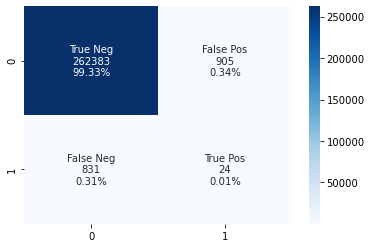

In [42]:
#Matrice de confusion
dt_matrix_val = confusion_matrix(test_target, gridsearchDT.predict(test_features))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                dt_matrix_val.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     dt_matrix_val.flatten()/np.sum(dt_matrix_val)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(dt_matrix_val, annot=labels, fmt='', cmap='Blues')

In [43]:
#Test
test_dt = round(f1_score(test_target, gridsearchDT.predict(test_features)),6)
print(metrics.classification_report(test_target, gridsearchDT.predict(test_features)))
print("Test score f1 : ", test_dt)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.03      0.03      0.03       855

    accuracy                           0.99    264143
   macro avg       0.51      0.51      0.51    264143
weighted avg       0.99      0.99      0.99    264143

Test score f1 :  0.026906


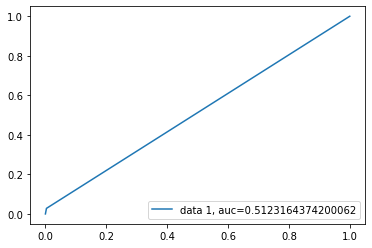

In [44]:
#Courbe ROC
fpr, tpr, _ = roc_curve(test_target, gridsearchDT.predict(test_features))
auc_dt = metrics.roc_auc_score(test_target, gridsearchDT.predict(test_features))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_dt))
plt.legend(loc=4)
plt.show()

In [164]:
test_result['DT'] = test_dt
valid_result['DT'] = f1_dt
auc_result['DT']=round(auc_dt,3)
time_result['DT']=round(DT,3)
print(test_result)
print(valid_result)
print(auc_result)
print(time_result)

{'KNN': 0.039632, 'DT': 0.080354}
{'KNN': 0.048721, 'DT': 0.030846}
{'KNN': 0.536, 'DT': 0.512}
{'KNN': 85.574, 'DT': 63.411}


### 7.3 Analyse discriminante linéaire

Nous avons décidé de présenter les résultats de l’analyse discriminante linéaire. En effet c’est un modèle relativement simple à mettre en œuvre dont les résultats sont facilement interprétable. De même, le temps de calcul est plutôt rapide quel que soit la taille des données et est stable sur des petits échantillons. 

In [58]:
#Création de pipeline
pipelineADL = make_pipeline(StandardScaler(),LinearDiscriminantAnalysis())

Afin de savoir les paramètres inclus dans l'ADL nous allons utiliser la fonction get_params().keys()

In [59]:
#Liste des paramètres
sorted(pipelineADL.get_params().keys())

['lineardiscriminantanalysis',
 'lineardiscriminantanalysis__n_components',
 'lineardiscriminantanalysis__priors',
 'lineardiscriminantanalysis__shrinkage',
 'lineardiscriminantanalysis__solver',
 'lineardiscriminantanalysis__store_covariance',
 'lineardiscriminantanalysis__tol',
 'memory',
 'standardscaler',
 'standardscaler__copy',
 'standardscaler__with_mean',
 'standardscaler__with_std',
 'steps',
 'verbose']

On obtient la liste des paramètres du modèle, que l'on peut essayer dans le gridsearch. Pour appliquer cette méthode, trois hyper-paramètres peuvent être utilisés le « solver », le «shrinkage» et le "tol". Le premier permet de changer la méthode de calcul et le second permet une régularisation lorsque la dimensionnalité augmente.

In [60]:
#Paramètres à tester
paramsADL = {'lineardiscriminantanalysis__solver':['svd', 'lsqr','eigen'],
             'lineardiscriminantanalysis__shrinkage':[None, 'auto'],
             'lineardiscriminantanalysis__tol':[0.0001,0.0002,0.0003]} #Paramètres à tester

In [61]:
tscv = TimeSeriesSplit(n_splits=5)
startADL = time()
#instanciation - recherche des hyperparametres optimaux
gridsearchADL = GridSearchCV(estimator=pipelineADL,
                       param_grid=paramsADL,
                       n_jobs=-1,
                       scoring='f1_micro')
gridsearchADL.fit(x_train_res, y_train_res)
doneADL = time()
ADL = round(doneADL - startADL)/60
print("Temps de calcul:",ADL)

Temps de calcul: 0.08499999999999999


On obtient le meilleur modèle:

In [62]:
#Meilleurs paramètres
print('Best Penalty:', gridsearchADL.best_estimator_.get_params()['lineardiscriminantanalysis__shrinkage'])
print('Best C:', gridsearchADL.best_estimator_.get_params()['lineardiscriminantanalysis__tol'])
print('Best solver:', gridsearchADL.best_estimator_.get_params()['lineardiscriminantanalysis__solver'])

Best Penalty: None
Best C: 0.0001
Best solver: svd


##### Validation :

Les métriques d'evaluation :

In [64]:
#Validation
f1_ADL = round(f1_score(y_val, gridsearchADL .predict(x_val)),6)
print(metrics.classification_report(y_val,gridsearchADL .predict(x_val)))
print("Validation score f1 : ", f1_ADL)

              precision    recall  f1-score   support

           0       1.00      0.88      0.94    288737
           1       0.02      0.57      0.03       948

    accuracy                           0.88    289685
   macro avg       0.51      0.72      0.48    289685
weighted avg       1.00      0.88      0.93    289685

Validation score f1 :  0.029688


##### Test :

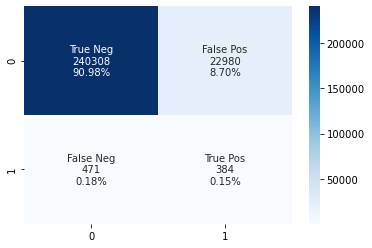

In [65]:
#Test
#Matrice de confusion
ADL_matrix_test = confusion_matrix(test_target, gridsearchADL.predict(test_features))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                ADL_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     ADL_matrix_test.flatten()/np.sum(ADL_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(ADL_matrix_test, annot=labels, fmt='', cmap='Blues')

In [68]:
#Test
test_ADL = round(f1_score(test_target,gridsearchADL.predict(test_features)),6)
print(metrics.classification_report(test_target,gridsearchADL.predict(test_features)))
print("Validation score f1 : ", test_ADL)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    263288
           1       0.02      0.45      0.03       855

    accuracy                           0.91    264143
   macro avg       0.51      0.68      0.49    264143
weighted avg       0.99      0.91      0.95    264143

Validation score f1 :  0.031711


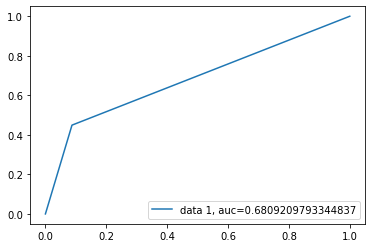

In [69]:
#Courbe ROC
fpr, tpr, _ = roc_curve(test_target, gridsearchADL.predict(test_features))
auc_adl = metrics.roc_auc_score(test_target,gridsearchADL.predict(test_features))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_adl))
plt.legend(loc=4)
plt.show()

Le F1 measure n'est pas très important mais l'AIC est beaucoup élevé. D'après, le modèle a bien prédit 384 cas frauds sur 855 cas. 

In [165]:
#Ajout dans le dico
test_result['ADL'] = test_ADL
valid_result['ADL'] = f1_ADL
auc_result['ADL'] = round(auc_adl,3)
time_result['ADL'] = round(ADL,3)
print(test_result)
print(valid_result)
print(auc_result)
print(time_result)

{'KNN': 0.039632, 'DT': 0.080354, 'ADL': 0.031711}
{'KNN': 0.048721, 'DT': 0.030846, 'ADL': 0.029688}
{'KNN': 0.536, 'DT': 0.512, 'ADL': 0.681}
{'KNN': 85.574, 'DT': 63.411, 'ADL': 5.1}


Le F1 maximum que l'on obtient avec cette algorithme est de 0.02 en utilisant les paramètres au-dessus. Le modèle ne semble pas adapter à notre problème.

### 7.4 Modèle ensembliste de SVM

Nous avons voulu essayer un SVM, tout d'abord seul et un modèle combinant plusieurs SVM. Ca n'a pas été concluant, nous n'avons pas réussi à faire tourné cet algorithme le temps d'execution est trop long. Les SVM ne sont pas adapté lorsque la base de données est trop importante.


In [ ]:
from sklearn.svm import SVC
pipeSVM = make_pipeline(StandardScaler(), SVC(gamma='auto'))
pipeSVM.fit(x_train_res, y_train_res) 
print ('Validation Results')
print (f1_score(y_val, pipeSVM.predict(x_val)))
print ('\nTest Results')
print (f1_score(test_target, pipeSVM.predict(test_features)))

In [ ]:
#bagging svm
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
bagging = make_pipeline(StandardScaler(), BaggingClassifier(SVC(), max_samples=0.5, max_features=0.5))
bagging.fit(x_train_res, y_train_res)
print ('Validation Results')
print (f1_score(y_val, bagging.predict(x_val)))

### 7.5 XGboost 

In [91]:
#xgboost
# avec cross_val_score
startboost = time()
xg_clas = make_pipeline(StandardScaler(),xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5,  alpha = 10, n_estimators = 10))
#preds = xg_clas.predict(x_val)
tscv = TimeSeriesSplit(n_splits=5)
results = cross_val_score(xg_clas,x_train_res,y_train_res, cv=tscv, scoring='f1_micro')
#print ('Validation croisé')
#print("resultat validation croisé:", results)
#print("f1 mesure: %.2f%% " % (results.mean()*100))
xg_clas.fit(x_train_res,y_train_res)
doneboost = time()
xg = round(doneboost - startboost,3)/60
print("Temps de calcul:",xg)

/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:36:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:36:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:36:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Temps de calcul: 0.7562666666666666


##### Validation :

In [51]:
#Validation

val_XGboost = round(f1_score(y_val, xg_clas.predict(x_val)),6)
print(metrics.classification_report(y_val, xg_clas.predict(x_val)))
print("Validation score f1 : ", val_XGboost)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    288737
           1       0.05      0.29      0.09       948

    accuracy                           0.98    289685
   macro avg       0.52      0.64      0.54    289685
weighted avg       0.99      0.98      0.99    289685

Validation score f1 :  0.085355


##### Test :

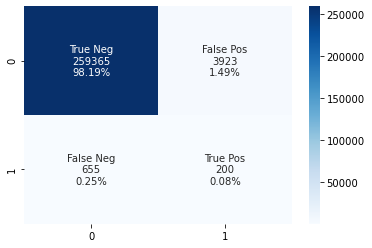

In [52]:
#Matrice de confusion
XG_matrix_test = confusion_matrix(test_target, xg_clas.predict(test_features))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                XG_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     XG_matrix_test.flatten()/np.sum(XG_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(XG_matrix_test, annot=labels, fmt='', cmap='Blues')

In [57]:
#Test
test_xgboost = round(f1_score(test_target, xg_clas.predict(test_features)),6)
print(metrics.classification_report(test_target, xg_clas.predict(test_features)))
print("Test score f1 : ", test_XG)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    263288
           1       0.05      0.23      0.08       855

    accuracy                           0.98    264143
   macro avg       0.52      0.61      0.54    264143
weighted avg       0.99      0.98      0.99    264143

Test score f1 :  0.080354


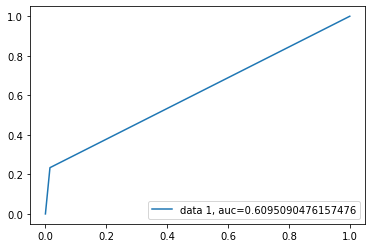

In [78]:
#Courbe ROC
fpr, tpr, _ = roc_curve(test_target, xg_clas.predict(test_features))
auc_xg= metrics.roc_auc_score(test_target,xg_clas.predict(test_features))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_xg))
plt.legend(loc=4)
plt.show()

In [169]:
#Ajout dans le dico
test_result['XGB'] = test_xgboost
valid_result['XGB'] = f1_xgboost
auc_result['XGB'] = round(auc_xg,3)
time_result['XGB'] = round(xg,3)
print(test_result)
print(valid_result)
print(auc_result)
print(time_result)

{'KNN': 0.039632, 'DT': 0.080354, 'ADL': 0.031711, 'XGB': 0.080354, 'ADXG': 0.083075}
{'KNN': 0.048721, 'DT': 0.030846, 'ADL': 0.029688, 'XGB': 0.085355, 'ADXG': 0.106159}
{'KNN': 0.536, 'DT': 0.512, 'ADL': 0.681, 'XGB': 0.61, 'ADXG': 0.538}
{'KNN': 85.574, 'DT': 63.411, 'ADL': 5.1, 'XGB': 0.756, 'ADXG': 1.934}


### 7.6 ADL x XGBoost ( Ensemble modeling )

In [142]:
VotingPredictorAR = VotingClassifier(estimators =
                           [('ADL', gridsearchADL), 
                            ('XG', xg_clas)],
                           voting='soft', n_jobs = 4)
start = time()
VotingPredictorAR = VotingPredictorAR.fit(x_train, y_train)
end = time()
AR= (end-start)/60
print(AR)

1.9340042153994241


##### Validation :

In [143]:
#Validation
f1_AR = round(f1_score(y_val, VotingPredictorAR.predict(x_val)),6)
print(metrics.classification_report(y_val,VotingPredictorAR.predict(x_val)))
print("Validation score f1 : ", f1_AR)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.10      0.11      0.11       948

    accuracy                           0.99    289685
   macro avg       0.55      0.55      0.55    289685
weighted avg       0.99      0.99      0.99    289685

Validation score f1 :  0.106159


##### Test :

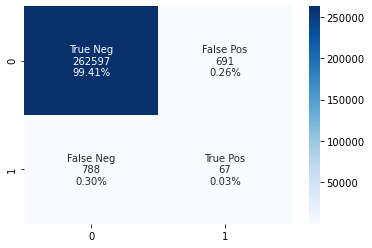

In [144]:
#Matrice de confusion
ADLRF_matrix_test = confusion_matrix(test_target, VotingPredictorAR.predict(test_features))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                ADLRF_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     ADLRF_matrix_test.flatten()/np.sum(ADLRF_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(ADLRF_matrix_test, annot=labels, fmt='', cmap='Blues')

In [145]:
#Test
test_AR = round(f1_score(test_target,VotingPredictorAR.predict(test_features)),6)
print(metrics.classification_report(test_target,VotingPredictorAR.predict(test_features)))
print("Validation score f1 : ", test_AR)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.09      0.08      0.08       855

    accuracy                           0.99    264143
   macro avg       0.54      0.54      0.54    264143
weighted avg       0.99      0.99      0.99    264143

Validation score f1 :  0.083075


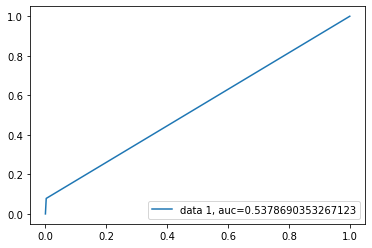

In [146]:
#Courbe ROC
fpr, tpr, _ = roc_curve(test_target, VotingPredictorAR.predict(test_features))
auc_ar= metrics.roc_auc_score(test_target,VotingPredictorAR.predict(test_features))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_ar))
plt.legend(loc=4)
plt.show()

In [168]:
#Ajout dans le dico
test_result['ADXG'] = test_AR
valid_result['ADXG'] = f1_AR
auc_result['ADXG'] = round(auc_ar,3)
time_result['ADXG'] = round(AR,3)
print(test_result)
print(valid_result)
print(auc_result)
print(time_result)

{'KNN': 0.039632, 'DT': 0.080354, 'ADL': 0.031711, 'XGB': 0.080354, 'ADXG': 0.083075}
{'KNN': 0.048721, 'DT': 0.030846, 'ADL': 0.029688, 'XGB': 0.085355, 'ADXG': 0.106159}
{'KNN': 0.536, 'DT': 0.512, 'ADL': 0.681, 'XGB': 0.6095090476157476, 'ADXG': 0.538}
{'KNN': 85.574, 'DT': 63.411, 'ADL': 5.1, 'XGB': 0.7562666666666666, 'ADXG': 1.934}


### 7.7 Random Forest

Le premier algorithme que nous avons tester est le random forest appelé en français la forêt aléatoire. Il consiste à assembler plusieurs arbres de décision.
Cette algorithme donne la possibilité d'affecter un poid en fonction de la classe. Nous allons donc tester la forêt aléatoire en utilisant les données ré échantillonné puis les données déséquilibrés en rajoutant un poids.

#### 7.7.1 Avec SMOTE


In [17]:
pipeRFS = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=100,min_samples_leaf=20,
n_estimators=500, n_jobs=-1, random_state=5, bootstrap=True, criterion='entropy'))
start = time()
pipeRFS.fit(x_train_res, y_train_res) 
end = time()
RFS = (end-start)/60
print("temps de calcul : ",RFS)

temps de calcul :  48.06304409901301


##### Validation :

In [18]:
f1_rfas = round(f1_score(y_val, pipeRFS.predict(x_val)),6)
print(metrics.classification_report(y_val, pipeRFS.predict(x_val)))
print ("Validation score f1:",f1_rfas)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.17      0.06      0.09       948

    accuracy                           1.00    289685
   macro avg       0.59      0.53      0.55    289685
weighted avg       0.99      1.00      1.00    289685

Validation score f1: 0.093918


##### Test :

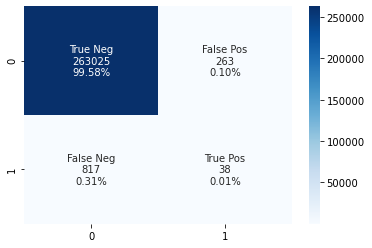

In [20]:
#Matrice de confusion
RFS_matrix_test = confusion_matrix(test_target,pipeRFS.predict(test_features))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                RFS_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     RFS_matrix_test.flatten()/np.sum(RFS_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RFS_matrix_test, annot=labels, fmt='', cmap='Blues')

In [19]:
#ajout des resultats dans le dico
test_rfas = round(f1_score(test_target, pipeRFS.predict(test_features)),6)
print(metrics.classification_report(test_target, pipeRFS.predict(test_features)))
print ("Test score f1:",test_rfas)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.13      0.04      0.07       855

    accuracy                           1.00    264143
   macro avg       0.56      0.52      0.53    264143
weighted avg       0.99      1.00      0.99    264143

Test score f1: 0.065744


Le f1 maximum que l'on a réussi à avoir avec cette algorithme est de 0.06, c'est un score pas très élevé, nous allons essayer de trouver un meilleur modèle.

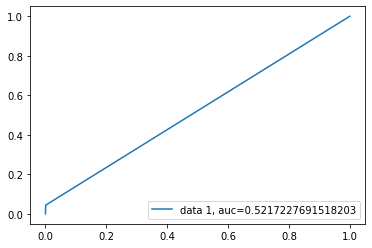

In [128]:
#Courbe ROC
fpr, tpr, _ = roc_curve(test_target,pipeRFS.predict(test_features))
auc_rfs = metrics.roc_auc_score(test_target, pipeRFS.predict(test_features))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_rfs))
plt.legend(loc=4)
plt.show()

In [170]:
test_result['RFSM'] = test_rfas
valid_result['RFSM'] = f1_rfas
auc_result['RFSM'] = round(auc_rfs,3)
time_result['RFSM'] = round(RFS,3)
print(test_result)
print(valid_result)
print(auc_result)
print(time_result)

{'KNN': 0.039632, 'DT': 0.080354, 'ADL': 0.031711, 'XGB': 0.080354, 'ADXG': 0.083075, 'RFSM': 0.065744}
{'KNN': 0.048721, 'DT': 0.030846, 'ADL': 0.029688, 'XGB': 0.085355, 'ADXG': 0.106159, 'RFSM': 0.093918}
{'KNN': 0.536, 'DT': 0.512, 'ADL': 0.681, 'XGB': 0.61, 'ADXG': 0.538, 'RFSM': 0.522}
{'KNN': 85.574, 'DT': 63.411, 'ADL': 5.1, 'XGB': 0.756, 'ADXG': 1.934, 'RFSM': 48.063}


#### 7.7.2 Sans SMOTE

Ici, nous utilison un random forest sans utiliser les données rééquilibrées avec un smote. On va accorder un poid en fonction de la classe. Pour ce faire on utilise l'option "class_weight" dans notre algortihme. La classe négative, non-fraude (0) est 370 fois plus présente que la classe fraude (1), donc nous allons mettre l'option "class_weight={0:1, 1:370}"

In [134]:
startRF = time()
RDbest1 = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:370}, criterion='entropy', max_depth=100,min_samples_leaf=20,
n_estimators=500, n_jobs=-1, random_state=5)
RDbest1.fit(x_train, y_train) 
doneRF = time()

tpsRF = round(doneRF - startRF,3)/60
print("temps de calcul" , tpsRF)

temps de calcul 9.095049999999999


##### Validation :

In [26]:
#Métriques d'évaluation
f1_rfss = round(f1_score(y_val, RDbest1.predict(x_val)),6)
print(metrics.classification_report(y_val, RDbest1.predict(x_val)))
print("Validation score f1:", f1_rfss )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.16      0.16      0.16       948

    accuracy                           0.99    289685
   macro avg       0.58      0.58      0.58    289685
weighted avg       0.99      0.99      0.99    289685

Validation score f1: 0.157978


Le score maximum que nous avons réussi à obtenir est de 16% ce qui est un bon score pour ce type de classification, c'est 2 fois plus qu'avec le modèle précédent. Voyons à présent si il est aussi bon sur l'échantillon de test. 

##### Test :

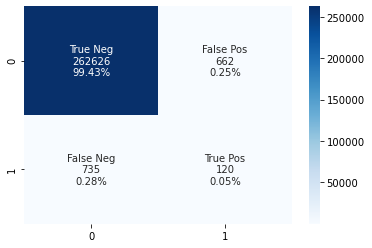

In [27]:
#Matrice de confusion
RDbest_matrix_test = confusion_matrix(test_target,RDbest1.predict(test_features))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                RDbest_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     RDbest_matrix_test.flatten()/np.sum(RDbest_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RDbest_matrix_test, annot=labels, fmt='', cmap='Blues')

Le modèle a detecé 120 cas de fraud sur l'ensemble de 855 fraudes qui est beaucoup mieux par rapport au modèle avec SMOTE.

In [28]:
test_rfss = round(f1_score(test_target,RDbest1.predict(test_features) ),6)
print(metrics.classification_report(test_target, RDbest1.predict(test_features)))
print("Test score f1:",test_rfss)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.15      0.14      0.15       855

    accuracy                           0.99    264143
   macro avg       0.58      0.57      0.57    264143
weighted avg       0.99      0.99      0.99    264143

Test score f1: 0.14661


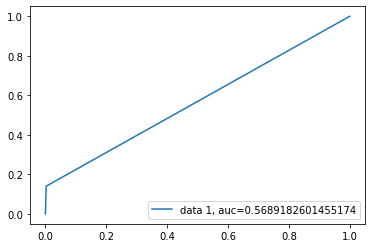

In [31]:
#Courbe ROC
fpr, tpr, _ = roc_curve(test_target,RDbest1.predict(test_features))
auc_rfss = metrics.roc_auc_score(test_target,RDbest1.predict(test_features))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_rfss))
plt.legend(loc=4)
plt.show()

Le AUC est à 0,56

In [173]:
#Ajout dictionnaire
test_result['RF'] = test_rfss
valid_result['RF'] = f1_rfss
auc_result['RF'] = round(auc_rfss,3)
time_result['RF'] = round(tpsRF,3)
print(test_result)
print(valid_result)
print(auc_result)
print(time_result)

{'KNN': 0.039632, 'DT': 0.080354, 'ADL': 0.031711, 'XGB': 0.080354, 'ADXG': 0.083075, 'RFSM': 0.065744, 'RF': 0.14661, 'IF': 0.129272}
{'KNN': 0.048721, 'DT': 0.030846, 'ADL': 0.029688, 'XGB': 0.085355, 'ADXG': 0.106159, 'RFSM': 0.093918, 'RF': 0.157978, 'IF': 0.031811}
{'KNN': 0.536, 'DT': 0.512, 'ADL': 0.681, 'XGB': 0.61, 'ADXG': 0.538, 'RFSM': 0.522, 'RF': 0.569, 'IF': None}
{'KNN': 85.574, 'DT': 63.411, 'ADL': 5.1, 'XGB': 0.756, 'ADXG': 1.934, 'RFSM': 48.063, 'RF': 9.095, 'IF': 0.48593333333333333}


### 7.8 One class Classification Isolation forest
Le dernier type de modèle que nous avons voulu essayer est un algorithme de type One-Class Classification. Ces algorithmes on pour objectif de détecter des anomalies dans les données en les isolants. Ils sont adaptés au données déséquilibrés comportant aucune ou très peu de données de la classe positif. Ce qui est le cas dans notre problème. Jusqu'a présent nos meilleurs résultat ont été obtenu avec la forêt aléatoire. Nous avons donc choisit le modèle isolation forest, qui repose également sur une représentation par arbre. C'est un algorithme d'apprentissage non-supervisé. 

In [88]:
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest

start = time()
# define outlier detection model
model = make_pipeline(StandardScaler(),IsolationForest(contamination='auto'))
trainX = x_train[y_train==0]
model.fit(trainX)
ypred = model.predict(x_val)
newy = y_val
newy[newy==1] = -1 
newy[newy==0]=1
done = time()
IR = round(done - start,3)/60
print("temps de calcul:",IR)

temps de calcul: 0.48593333333333333


<ipython-input-88-aca5f0dfdd4b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newy[newy==1] = -1
/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-88-aca5f0dfdd4b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newy[newy==0]=1


##### Validation :

In [82]:
#Validation
f1_iforest = round(f1_score(newy,ypred, pos_label=-1),6)
print(metrics.classification_report(newy, ypred))
print('Validation F1 Score:' ,f1_iforest)

              precision    recall  f1-score   support

          -1       0.02      0.40      0.03       948
           1       1.00      0.92      0.96    288737

    accuracy                           0.92    289685
   macro avg       0.51      0.66      0.50    289685
weighted avg       0.99      0.92      0.96    289685

Validation F1 Score: 0.031811


##### Test :

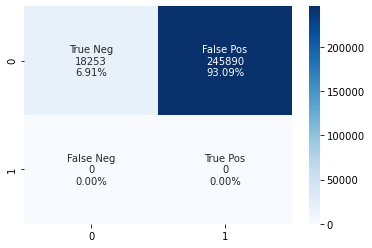

In [85]:
#Matrice de confusion
IR_matrix_test = confusion_matrix(newy_test,ypred_test)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                IR_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     IR_matrix_test.flatten()/np.sum(IR_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(IR_matrix_test, annot=labels, fmt='', cmap='Blues')

In [84]:
#test
newy_test = test_target
newy_test[newy_test==1] = -1 
newy_test[newy_test==0]=1
ypred_test = model.predict(test_features)
test_iforest = round(f1_score(newy_test,ypred_test, pos_label=-1),6)
print(metrics.classification_report(newy_test,ypred_test))
print('Validation F1 Score:' ,test_iforest)

<ipython-input-84-6557a4093bd3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newy_test[newy_test==1] = -1
/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-84-6557a4093bd3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newy_test[newy_test==0]=1


              precision    recall  f1-score   support

          -1       1.00      0.07      0.13    264143
           1       0.00      0.00      0.00         0

    accuracy                           0.07    264143
   macro avg       0.50      0.03      0.06    264143
weighted avg       1.00      0.07      0.13    264143

Validation F1 Score: 0.129272


/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A cause de l'isolation de la classe 1 donc nous n'avons pas de courbe de ROC

Nous pouvons voir que il y a une grande différence entre le F1 de test et val donc le modèle n'est pas très fiable

In [200]:
#Ajout dans le dico
test_result['IF'] = test_iforest
valid_result['IF'] = f1_iforest
auc_result['IF'] = 0
time_result['IF'] = round(IR,3)
print(test_result)
print(valid_result)
print(auc_result)
print(time_result)

{'KNN': 0.039632, 'DT': 0.080354, 'ADL': 0.031711, 'XGB': 0.080354, 'ADXG': 0.083075, 'RFSM': 0.065744, 'RF': 0.14661, 'IF': 0.129272}
{'KNN': 0.048721, 'DT': 0.030846, 'ADL': 0.029688, 'XGB': 0.085355, 'ADXG': 0.106159, 'RFSM': 0.093918, 'RF': 0.157978, 'IF': 0.031811}
{'KNN': 0.536, 'DT': 0.512, 'ADL': 0.681, 'XGB': 0.61, 'ADXG': 0.538, 'RFSM': 0.522, 'RF': 0.569, 'IF': 0}
{'KNN': 85.574, 'DT': 63.411, 'ADL': 5.1, 'XGB': 0.756, 'ADXG': 1.934, 'RFSM': 48.063, 'RF': 9.095, 'IF': 0.486}


## 8. Résultats et comparaison 

##### F1 - Validation :

OrderedDict([('RF', 0.157978), ('ADXG', 0.106159), ('RFSM', 0.093918), ('XGB', 0.085355), ('KNN', 0.048721), ('IF', 0.031811), ('DT', 0.030846), ('ADL', 0.029688)])


<BarContainer object of 8 artists>

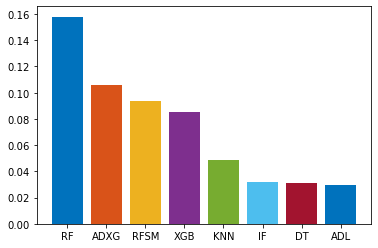

In [185]:
#barre plot validation
tab_valid=OrderedDict(sorted(valid_result.items(), key=lambda t: t[1], reverse=True))
print(tab_valid)
plt.bar(tab_valid.keys(),tab_valid.values(),color=['#0072BD','#D95319','#EDB120','#7E2F8E','#77AC30','#4DBEEE','#A2142F'])

##### F1 - Test :

OrderedDict([('RF', 0.14661), ('IF', 0.129272), ('ADXG', 0.083075), ('DT', 0.080354), ('XGB', 0.080354), ('RFSM', 0.065744), ('KNN', 0.039632), ('ADL', 0.031711)])


<BarContainer object of 8 artists>

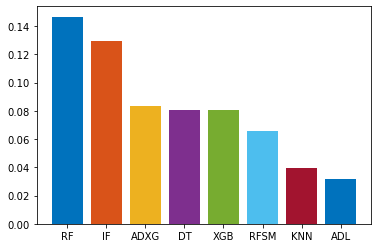

In [187]:
#barre plot test
tab_test=OrderedDict(sorted(test_result.items(), key=lambda t: t[1], reverse=True))
print(tab_test)
plt.bar(tab_test.keys(),tab_test.values(),color=['#0072BD','#D95319','#EDB120','#7E2F8E','#77AC30','#4DBEEE','#A2142F'])

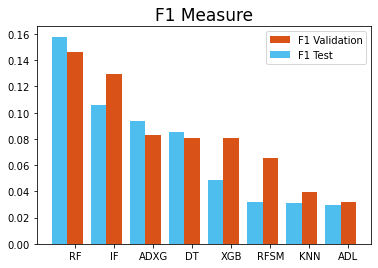

In [196]:
M = np.arange(len(tab_test))
ax = plt.subplot(111)
ax.bar(M, tab_test.values(), width=0.4, color='#D95319', align='center')
ax.bar(M-0.4, tab_valid.values(), width=0.4, color='#4DBEEE', align='center')
ax.legend(('F1 Validation','F1 Test'))
plt.xticks(M, tab_test.keys())
plt.title("F1 Measure", fontsize=17)
plt.show()

##### AUC :

OrderedDict([('ADL', 0.681), ('XGB', 0.61), ('RF', 0.569), ('ADXG', 0.538), ('KNN', 0.536), ('RFSM', 0.522), ('DT', 0.512), ('IF', 0)])


<BarContainer object of 8 artists>

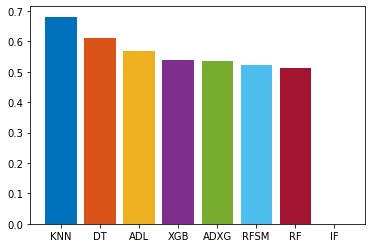

In [202]:
#barre plot test
tab_AUC=OrderedDict(sorted(auc_result.items(), key=lambda t: t[1], reverse=True))
print(tab_AUC)
plt.bar(auc_result.keys(),tab_AUC.values(),color=['#0072BD','#D95319','#EDB120','#7E2F8E','#77AC30','#4DBEEE','#A2142F'])

##### Temps de calcul :

OrderedDict([('KNN', 85.574), ('DT', 63.411), ('RFSM', 48.063), ('RF', 9.095), ('ADL', 5.1), ('ADXG', 1.934), ('XGB', 0.756), ('IF', 0.486)])


<BarContainer object of 8 artists>

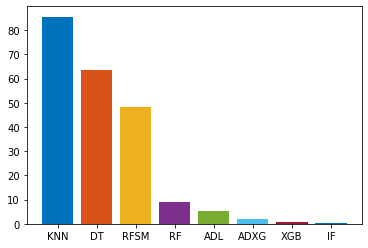

In [209]:
#barre plot test
tab_temps=OrderedDict(sorted(time_result.items(), key=lambda t: t[1], reverse=True))
print(tab_temps)
plt.bar(tab_temps.keys(),tab_temps.values(),color=['#0072BD','#D95319','#EDB120','#7E2F8E','#77AC30','#4DBEEE','#A2142F'])

## 9. Conclusion sur F1 

En transformant le fromule de F1, nous avons:

F1 := 2 / (1/precision + 1/rapel).

Pourquoi le F1 est toujours petit ? Est ce que ca veut dire que notre modèle est mauvais ?

Pour répondre à ces questions, nous examinons le meilleur score que nous pouvons atteindre sans aucune connaissance, par exemple en lançant une pièce. Cette pièce peut être injuste. Soit p la probabilité que la pièce prédit un résultat positif, c'est-à-dire qu'une pièce parfaitement juste aurait p = 0,5. Soit q la part des cas positifs réels. Dans ce scénario, il n'est pas difficile de déduire des définitions que précision = q et rappel = p. Par conséquent, la précision n'est pas influencée par la configuration de notre pièce. Et le rappel est meilleur si la pièce prédit toujours positif (p = 1).Étonnamment, prédire toujours positif est le mieux que nous puissions faire en termes de score F1 si nous n'avons aucune information. Cela est dû au fait que le score F1 n'est pas symétrique entre les cas positifs et négatifs. Il accorde plus d'attention aux cas positifs. Nous avons le F1 max: 

F1_p = 2/((1/q + 1/1)) =2/((1+q)/q) = 2q/(1+q)

Nous allons voir le changement de F1 selon q :


In [214]:
from astropy.table import QTable, Table, Column
row = ["Tout negative","Peu positif","Balance","Peu negatif","Tout positif"]
col1 = [0, 0.1, 0.5, 0.9, 1]
col2 = [0, 0.19, 0.66,0.95,1]
t = Table([row,col1,col2], names=('Type','Taux positif q', 'F1'))
print(t)

     Type     Taux positif q  F1 
------------- -------------- ----
Tout negative            0.0  0.0
  Peu positif            0.1 0.19
      Balance            0.5 0.66
  Peu negatif            0.9 0.95
 Tout positif            1.0  1.0


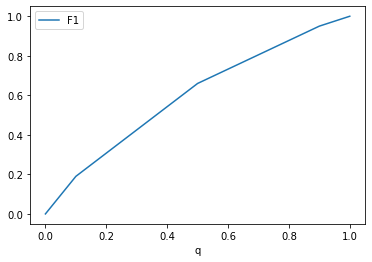

In [231]:
d = {'q': col1, 'F1': col2}
d = pd.DataFrame(d)
d.plot(x='q',y='F1')

Da graphique, ca montre que le F1 dépend fortement du déséquilibre de notre jeu de données.

## 10. Bonus

Nous voudrons maximiser le chiffre d'affaire 

### 10.1 Analyse Univarié

Une vue globale sur les 2 classes

In [67]:
print ("Fraud")
print (df.MontAnt[df.FlAgImpAye == 1].describe())
print ()
print ("Normal")
print (df.MontAnt[df.FlAgImpAye == 0].describe())

Fraud
count    6257.000000
mean       94.557721
std       133.659270
min         3.170000
25%        31.160000
50%        50.630000
75%       103.240000
max      3825.610000
Name: MontAnt, dtype: float64

Normal
count    2.225112e+06
mean     5.982031e+01
std      7.958524e+01
min      1.000000e-02
25%      2.500000e+01
50%      4.233000e+01
75%      7.200000e+01
max      1.698534e+04
Name: MontAnt, dtype: float64


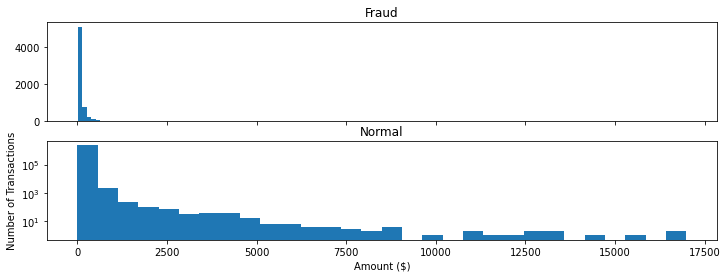

In [65]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(df.MontAnt[df.FlAgImpAye == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.MontAnt[df.FlAgImpAye == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

La moyenne des transactions frauduleax sont plus élevés que celle du normal, cependant, la distribution du normal est beaucoup plus large. Le montant maximum de la classe normale est clairement supérier que celui du fraud.

On va observer la distribution des 2 classes selon Heure :

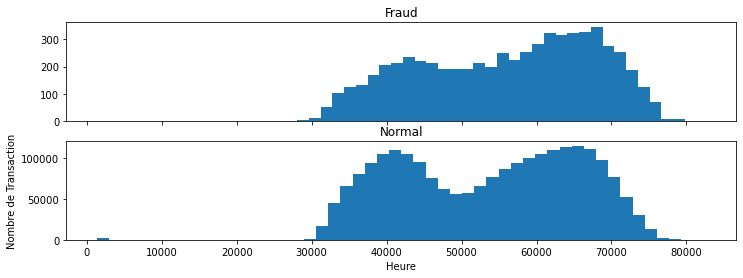

In [62]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Heure[df.FlAgImpAye  == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Heure[df.FlAgImpAye  == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Heure')
plt.ylabel('Nombre de Transaction')
plt.show()

La distribution des deux classe selon Heure sont similaire. On pourrais assuler que les transations frauduleux sont plus gaussiens que les transactions normaux.


Les chiffre d'affaire des 2 classes selon Mois :

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Mois[df.FlAgImpAye  == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Mois[df.FlAgImpAye  == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Mois')
plt.ylabel('Nombre de Transaction')
plt.show()

### 10.2. Chiffre d'affaire origin

Le CA origin est caculé basé sur tous les transactions normaux 

In [233]:
b=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
CAorigin = np.sum(b[test_target==0])
print(CAorigin)

15436477.790000001


### 10.3. Les Modèles pour maximiser le CA

- si on accepte une bonne transaction (TN) : le chiffre d’affaire généré est égal au montant de la transaction f(m) = m
- si on accepte une mauvaise transaction (FN) : le chiffre d’affaire perdu est proportionnel au montant à f(m) = m(1 − exp(-m))
Plus le montant de la transaction est élevé,
plus la perte est importante.
- lorsque vous refusez une bonne transaction (FP) : vous générez un chiffre d’affaire égal à 80% du montant de la transaction, f(m) = 0.8m
- lorsque vous refusez une transaction frauduleuse, le chiffre d’affaire est nul f(m) = 0

On a le formule de chiffre d'affaire :

                                CA_Modèle = TN -FN*(1-exp(-FN))+0.8*FP+0*TP

Afin d'obtenir le resultat selon les méthodes proposé, nous avons développé 2 formules qui sont pris l'advantage de la class 0 et 1. 


a=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()

a égale les valeurs de Montant de Test

a=(1-test_target.to_numpy())*0.2*a + test_target.to_numpy()*a*(1-np.exp(-a))
print(a)


On a test_target = 1 ou 0 :

- Cas 1 : test_target = 1 => Fraud 

    a = (1 - 1)*0.2*a + 1*a*(1-exp(-a))
  = 0             + a(1-exp(-a))
  = a(1-exp(-a))

- Cas 2 : test_target = 0 => Normal

    a = (1 - 0)*0.2*a + 0*a*(1-exp(-a))
  = 0.2*a



b=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()

b égale les valeurs de Montant de Test

CA=np.sum(b[test_target==0]) - np.sum(((RDbest4.predict(test_features)-test_target)**2)*a)

np.sum(b[test_target==0]) = Chiffre d'affaire origin

Donc maintenant, on va étudier les cas de la fonction suivant qui suppose d'être les pertes.

RDbest4.predict(test_features)-test_target


- Cas 1 : test_target = 1 => Fraud 
    a = a(1-exp(-a))

    - Cas 1.1 : test_feature = predict= 1  => Vrai Positif 
    
        (((RDbest4.predict(test_features)-test_target)**2)*a)
        ((1-1)^2)*a =0

        Donc on enleve rien 

    - Cas 1.2 : test_feature = predict= 0  => Faux Negatif
        ((RDbest4.predict(test_features)-test_target)**2)*a)
        ((0-1)^2)*a =1*a = a =  a(1-exp(-a))
        Donc on enleve: a(1-exp(-a))


- Cas 2 : test_target = Flag = 0  => Normal
    a = 0.2*a

    - Cas 2.1 : test_feature = predict= 1  => Faux Positif 
        (((RDbest4.predict(test_features)-test_target)**2)*a)
        ((1-0)^2)*a =1*a = a =0.2*a 
        Donc on enleve 0.2*a

    - Cas 2.2 : test_feature = predict= 0  => VN
      ((RDbest4.predict(test_features)-test_target)**2)*a)
      ((0-0)^2)*a =0
        Donc on enleve rien 

#### 10.3.1. Random Forest - Forêt aléatoire

Comme le premier partie, avec le meilleur modèle pour F1, nous allons tester pour savoir la difference de la prédiction.

In [71]:
startRF = time()
RDbestCA = make_pipeline(StandardScaler(),RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:375}, criterion='entropy', max_depth=200,min_samples_leaf=20,
n_estimators=500, n_jobs=-1, random_state=5))
RDbestCA.fit(x_train, y_train) 
doneRF = time()

tpsRF = round(doneRF - startRF,3)
print("temps de calcul" , tpsRF/60)

print(metrics.classification_report(test_target, RDbestCA.predict(test_features)))
print("Score f1:",f1_score(test_target,RDbestCA.predict(test_features) ))
print(metrics.classification_report(y_val, RDbestCA.predict(x_val)))
print ("Score f1:",f1_score(y_val, RDbestCA.predict(x_val)))

temps de calcul 11.671016666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.16      0.14      0.15       855

    accuracy                           0.99    264143
   macro avg       0.58      0.57      0.57    264143
weighted avg       0.99      0.99      0.99    264143

Score f1: 0.14606741573033707
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.16      0.16      0.16       948

    accuracy                           0.99    289685
   macro avg       0.58      0.58      0.58    289685
weighted avg       0.99      0.99      0.99    289685

Score f1: 0.15849843587069862


In [73]:
a=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
a=(1-test_target.to_numpy())*0.2*a + test_target.to_numpy()*a*(1-np.exp(-a))
b=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
CA_RD=np.sum(b[test_target==0])-np.sum(((RDbestCA.predict(test_features)-test_target)**2)*a)
print(CA_RD)

[ 45.41  62.06  16.43 ... 186.51  38.54  13.93]
15353024.300848942


In [76]:
print(CAorigin-CA_RD)

83453.48915105872


Donc notre resultat est environ 83k$ moins que par rapport le CA original. Le but est de minimiser ce différent.

#### 10.3.2 Random Forest avec Sample_weight

On va utiliser maitenant l’option sample_weight: plus le montant perdu pour une transaction élevé,
plus de chance d’être bon classé pour cette transaction.

Donc on essaie de fit le meilleur modele avec sample_weight = montant_lost ou montant_lost est le montant perdu de test 

In [77]:
entrainement = Apprenti.loc[df['DAteTrAnsAction'] < '2016-08-20'] 
data= entrainement.drop(Apprenti.columns[[0, 1, 3,21]], axis=1) 
sc=StandardScaler()
sc.fit(data)
NormalizeY = data['FlAgImpAye']
NormalizeX = data.drop(data.columns[[18]], axis=1) 

In [80]:
startRF = time()

RDSW = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:375}, criterion='entropy', max_depth=200,min_samples_leaf=20,
n_estimators=500, n_jobs=-1, random_state=5)


montant=x_train['MontAnt'].to_numpy()
montant_loss=(1-y_train.to_numpy())*0.2*montant+y_train.to_numpy()*montant*(1-np.exp(-montant))

RDSW.fit(NormalizeX, NormalizeY, sample_weight= montant_loss) 
doneRF = time()

tpsRF = round(doneRF - startRF,3)
print("temps de calcul" , tpsRF/60)

temps de calcul 11.549566666666667


In [81]:
print(metrics.classification_report(test_target, RDSW.predict(test_features)))
print("Score f1:",f1_score(test_target,RDSW.predict(test_features) ))
print(metrics.classification_report(y_val, RDSW.predict(x_val)))
print ("Score f1:",f1_score(y_val, RDSW.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.09      0.14      0.11       855

    accuracy                           0.99    264143
   macro avg       0.54      0.57      0.55    264143
weighted avg       0.99      0.99      0.99    264143

Score f1: 0.11044638748274273
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    288737
           1       0.10      0.17      0.12       948

    accuracy                           0.99    289685
   macro avg       0.55      0.58      0.56    289685
weighted avg       0.99      0.99      0.99    289685

Score f1: 0.12260835611089418


In [82]:
a=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
a=(1-test_target.to_numpy())*0.2*a + test_target.to_numpy()*a*(1-np.exp(-a))
b=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
CA_RDSW=np.sum(b[test_target==0])-np.sum(((RDSW.predict(test_features)-test_target)**2)*a)
print(CA_RDSW)

15353730.078848733


In [83]:
print(CAorigin-CA_RDSW)

82747.71115126833


Nous avons 82k$ en différence, donc on avance 1k de plus par rapport au modèle simple de Random Forest.

#### 10.3.3. Abre de décision 

In [234]:
a=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
a=(1-test_target.to_numpy())*0.2*a + test_target.to_numpy()*a*(1-np.exp(-a))
b=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
CA_DT=np.sum(b[test_target==0])-np.sum(((gridsearchDT.predict(test_features)-test_target)**2)*a)
print(CA_DT)
print(CAorigin-CA_DT)

15338705.322848309
97772.46715169214


#### 10.3.4. ADL

In [235]:
a=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
a=(1-test_target.to_numpy())*0.2*a + test_target.to_numpy()*a*(1-np.exp(-a))
b=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
CA_DT=np.sum(b[test_target==0])-np.sum(((gridsearchADL.predict(test_features)-test_target)**2)*a)
print(CA_DT)
print(CAorigin-CA_DT)

15012182.070750276
424295.71924972534


#### 10.3.5. XGBoost

In [236]:
a=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
a=(1-test_target.to_numpy())*0.2*a + test_target.to_numpy()*a*(1-np.exp(-a))
b=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
CA_XG=np.sum(b[test_target==0])-np.sum(((xg_clas.predict(test_features)-test_target)**2)*a)
print(CA_XG)
print(CAorigin-CA_XG)

15281358.332843106
155119.45715689473


#### 10.3.6. ADxXG

In [237]:
a=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
a=(1-test_target.to_numpy())*0.2*a + test_target.to_numpy()*a*(1-np.exp(-a))
b=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
CA_ADXG=np.sum(b[test_target==0])-np.sum(((VotingPredictorAR.predict(test_features)-test_target)**2)*a)
print(CA_ADXG)
print(CAorigin-CA_ADXG)

15320522.120849116
115955.6691508852


## 11. Conclusion

# Exporter and save 

In [121]:
  #%notebook '/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/ProjetFraud/BIG DATA.ipynb'